# IMO zadanie 5 - Hybrydowy algorytm ewolucyjny

Emilia Maciejewska <br>
Anita Zielińska

In [1]:
import tsplib95
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import datetime
import statistics

## 0. Wczytywanie danych

In [2]:
problemA = tsplib95.load("kroA200.tsp")
problemA = problemA.as_keyword_dict()

In [3]:
problemB = tsplib95.load("kroB200.tsp")
problemB = problemB.as_keyword_dict()

In [4]:
def create_distance_matrix(data):
    dict_length = len(data['NODE_COORD_SECTION'])
    distance_matrix = np.zeros((dict_length, dict_length), dtype=int)
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix[i])):
            x1 = data['NODE_COORD_SECTION'][i+1]
            x2 = data['NODE_COORD_SECTION'][j+1]
            d = math.floor(math.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2) + 0.5)
            distance_matrix[i][j] = d
    return distance_matrix

In [5]:
distance_matrix_A = create_distance_matrix(problemA)
distance_matrix_B = create_distance_matrix(problemB)

## 1. Algorytm startowy

In [122]:
def selectStartingPoints(id):
    if id == 'A':
        max_id = len(distance_matrix_A) - 1 
    else:
        max_id = len(distance_matrix_B) - 1 
    p1 = random.randint(0, max_id)
    p2 = random.randint(0, max_id)
    while p2 == p1:
        p2 = random.randint(0, max_id)
    return p1, p2

In [123]:
def greedy_start(experimentId, p1, p2):
    matrix_length = 0
    d_matrix = []
    if experimentId == 'A':
        matrix_length = len(distance_matrix_A) 
        d_matrix = distance_matrix_A
    else:
        matrix_length = len(distance_matrix_B)  
        d_matrix = distance_matrix_B
        
    selected = dict()
    selected[p1] = 1
    selected[p2] = 1
    result = [[p1],[p2]]
    resultVal = [[0],[0]]
    
    notSelected = []
    for j in range (matrix_length):
        if j != p1 and j != p2:
            notSelected.append(j)

    cycleId = 0
    while len(selected) < matrix_length:
        newDist = np.inf
        newArr = []
        newItem = np.inf
        
        random.shuffle(notSelected)
        pr = math.ceil(len(notSelected)*0.1)
        
        for i in range(pr):
            if notSelected[i] not in selected:
                for j in range(len(result[cycleId])+1):
                    new = result[cycleId][:j]
                    new.append(notSelected[i])
                    new += result[cycleId][j:]
                    dist = 0
                    for k in range(1, len(new)):
                        dist += d_matrix[new[k-1]][new[k]]
                    if dist < newDist:
                        newDist = dist
                        newArr = new
                        newItem = notSelected[i]
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        notSelected.remove(newItem)
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    resultVal[0] += d_matrix[result[0][len(result[0]) - 1]][result[0][0]]
    resultVal[1] += d_matrix[result[1][len(result[1]) - 1]][result[1][0]]
    result[0].append(result[0][0])
    result[1].append(result[1][0])
    return result, resultVal

## 2. Lokalne przeszukiwanie w wersji stromej (wierzchołki + krawędzie)

### 2.1 Sąsiedztwo międzytrasowe wierzchołki

In [124]:
def neighborExternalV (experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    for i in range(1, len(aA)-1):
        for j in range(1, len(aB)-1):
            dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
            dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
            dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
            dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
            d = dis2 - dis1
            if d < delta:
                delta = d
                r = [aA[i], aB[j]]
    return delta, r

### 2.2 Sąsiedztwo wewnątrztrasowe krawędzie

In [125]:
def neighborInternalESingle (mat, aA, delta, r):
    for i in range(1, len(aA)):
        for j in range(i+1,  len(aA)-1):
            if i+1 != j:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0 and d < delta:
                    delta = d
                    r = [aA[i], aA[j]]
    return delta, r

In [126]:
def neighborInternalE (experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    delta1, r1 = neighborInternalESingle(mat, aA, delta, r)
    delta2, r2 = neighborInternalESingle(mat, aB, delta, r)
    if delta1 < delta2:
        return delta1, r1, "0"
    else:
        return delta2, r2, "1"

### 2.3 Lokalne przeszukiwanie

In [127]:
def steepestE (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = -1
    r = []
    
    while delta < 0:
        newResult = [[],[]]
        newResultVal = [0, 0]
        delta1, r1 = neighborExternalV(experimentId, result)
        delta2, r2, cycleId = neighborInternalE(experimentId, result)
        if delta1 < delta2: # lepsza była zmiana międzytrasowa
            r = r1
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if i == 0 and result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif i == 1 and result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        else:
            r = r2
            tempA = []
            cycleId = int(cycleId)
            index1 = np.where(result[cycleId] == r[0])
            index2 = np.where(result[cycleId] == r[1])
            tempA = np.copy(result[cycleId])
            tempA = tempA[index1[0][0]+1: index2[0][0]]
            
            if cycleId == 1:
                newResultVal[0] = np.copy(resultVal[0])
                newResult[0] = np.copy(result[0])
            else:
                newResultVal[1] = np.copy(resultVal[1])
                newResult[1] = np.copy(result[1])
            
            tempA = np.flip(tempA)
            flag = False
            ind = 0
            for j in range(len(result[cycleId])):
                if result[cycleId][j] == r[0]:
                    newResult[cycleId].append(r[1])
                    ind = 0
                    flag = True
                elif result[cycleId][j] == r[1]:
                    newResult[cycleId].append(r[0])
                    flag = False
                elif flag == True:
                    newResult[cycleId].append(tempA[ind])
                    ind +=1
                else:
                    newResult[cycleId].append(result[cycleId][j])
                if len(newResult[cycleId]) > 1:
                    newResultVal[cycleId] += mat[newResult[cycleId][-2]][newResult[cycleId][-1]]

        delta = newResultVal[0] + newResultVal[1] - resultVal[0] - resultVal[1]
        result = np.copy(newResult)
        resultVal = np.copy(newResultVal)
        
    return result, resultVal

## 3. Hybrydowy algorytm ewolucyjny (HAE)

In [190]:
def repair(experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    matrix_length = len(mat)

    selected = dict()
    for i in range(len(result)):
        for j in range(len(result[i])):
            selected[result[i][j]] = 1
    resultVal = [[0],[0]]
    
    cycleId = 0
    while len(selected) < matrix_length:
        newDist = np.inf
        newArr = []
        newItem = np.inf
        for i in range(matrix_length):
            if i not in selected:
                for j in range(len(result[cycleId])+1):
                    new = result[cycleId][:j]
                    new = np.append(new, i)
                    new = np.concatenate((new, result[cycleId][j:]))
                    new = new.astype(int)
                    dist = 0
                    for k in range(1, len(new)):
                        dist += mat[int(new[k-1])][int(new[k])]
                    if dist < newDist:
                        newDist = dist
                        newArr = new
                        newItem = i
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        if cycleId == 0 and len(result[1]) < 100:
            cycleId = 1
        elif cycleId == 1 and len(result[0]) < 100:
            cycleId = 0
    resultVal[0] += mat[result[0][len(result[0]) - 1]][result[0][0]]
    resultVal[1] += mat[result[1][len(result[1]) - 1]][result[1][0]]
    result[0] = np.append(result[0], result[0][0])
    result[1] = np.append(result[1], result[1][0])
    nResult = np.copy(result)
    return nResult, resultVal

In [218]:
def hae(experimentId, time_avg=100):
    
    population_size = 20
    population = []
    population_val = []
    while len(population) < population_size:
        p1, p2 = selectStartingPoints(experimentId)
        start, startVal = greedy_start(experimentId, p1, p2)
        bestR, bestV = steepestE(experimentId, start, startVal)
        if (bestV[0]+bestV[1]) not in population_val:
            best0 = np.insert(bestR[0], 0, bestR[0][-2])
            best1 = np.insert(bestR[1], 0, bestR[1][-2])
            population.append([best0, best1])
            population_val.append(bestV[0]+bestV[1])
    pop = np.array(population)
    pop_val = np.array(population_val)
    print("start val", pop_val)
    start_time = datetime.datetime.now()
    execution_time = 0
    while execution_time < time_avg:
        max_id = len(pop) - 1 
        parent1 = random.randint(0, max_id)
        parent2 = random.randint(0, max_id)
        while parent1 == parent2:
            parent2 = random.randint(0, max_id)
        newChild = [[],[]]
        for i in range (len(pop[parent1])):
            for j in range (1, len(pop[parent1][i])-1):
                value = pop[parent1][i][j]
                p_id = list(zip(*np.where(pop[parent2] == value)))
                if len(p_id) == 1:
                    if (pop[parent1][i][j-1] == pop[parent2][p_id[0][0]][p_id[0][1]-1] or pop[parent1][i][j+1] == pop[parent2][p_id[0][0]][p_id[0][1]+1]):
                        newChild[i].append(value)
        newChild1 = np.array(newChild[0])
        newChild2 = np.array(newChild[1])
        newChildA = [newChild1, newChild2]
        if len(newChildA[0])>0 and len(newChildA[1])>0:
            newR, newV = repair(experimentId, newChildA)
            #newR, newV = steepestE(experimentId, rR, rV)
            if newV[0]+newV[1] < np.max(pop_val) and newV[0]+newV[1] not in pop_val :
                max_item_d = np.argmax(pop_val)
                newB0 = np.insert(newR[0], 0, newR[0][-2])
                newB1 = np.insert(newR[1], 0, newR[1][-2])
                pop[max_item_d] = [newB0, newB1]
                pop_val[max_item_d] = newV[0]+newV[1]

        end_time = datetime.datetime.now()    
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000   
    min_index = np.argmin(pop_val)
    result = pop[min_index]
    resultSub1 = result[0][:-1]
    resultSub2 = result[1][:-1]
    result_val = pop_val[min_index]
    print("result", [resultSub1, resultSub2])
    print("result_val", result_val)
    return [resultSub1, resultSub2], result_val, execution_time  


## 6. Przygotowanie wyników

In [202]:
problemA['NODE_COORD_SECTION']
dataA = []
for i in range(1, len(problemA['NODE_COORD_SECTION'])+1):
    dataA.append(problemA['NODE_COORD_SECTION'][i])
dataArrA = np.array(dataA)

In [203]:
problemB['NODE_COORD_SECTION']
dataB = []
for i in range(1, len(problemB['NODE_COORD_SECTION'])+1):
    dataB.append(problemB['NODE_COORD_SECTION'][i])
dataArrB = np.array(dataB)

In [204]:
def print_plot(data, points, title, fileName):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points[0], 0], data[points[0], 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points[0], 0], data[points[0], 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.plot(data[points[1], 0], data[points[1], 1], "o", color='tab:red',  linewidth=0, alpha=0.6)
    plt.plot(data[points[1], 0], data[points[1], 1], "--", color="tab:orange", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(False)
    
    plt.show()
    f.savefig(fileName, bbox_inches='tight')

In [205]:
def summarizeStart(result, resultVal, title, dataArr):
    valueArray = np.array(resultVal)
    print("wyniki algorytmu")
    print("min", np.min(valueArray))
    print("max", np.max(valueArray))
    print("mean", np.mean(valueArray))
    index = np.argmin(valueArray)
    print_plot(dataArr, result[index], title, title + ".png")
    plt.show()

In [206]:
def summarize(result, resultVal, timeT, title, dataArr):
    valueArray = np.array(resultVal)
    timeArray = np.array(timeT)
    print("wyniki algorytmu")
    print("min", np.min(valueArray))
    print("max", np.max(valueArray))
    print("mean", np.mean(valueArray))
    index = np.argmin(valueArray)
    print(index)
    print(valueArray)
    print("czas obliczeń")
    print("min", np.min(timeArray))
    print("max", np.max(timeArray))
    print("mean", np.mean(timeArray))
    print_plot(dataArr, result[index], title, title + ".png")
    plt.show()

## 7. Eksperyment A

In [231]:
resultHae = []
resultValHae = []
timeHae = []
resultHae1 = []
resultValHae1 = []
timeHae1 = []

In [232]:
def runExperiment(experimentId):
    itersNumber = 1
    
    for i in range(itersNumber):
        print("nr iteracji ", i)
    
        #hae
        start_time = datetime.datetime.now()
        r,v,t = hae(experimentId, 365000) #400000
        end_time = datetime.datetime.now()
        resultHae.append(r)
        resultValHae.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeHae.append(t)


In [ ]:
runExperiment('A')

nr iteracji  0
start val [38311 34107 35581 36745 36464 36262 37296 37441 39660 35145 35997 36706
 35947 36648 34897 37447 37023 37170 36541 36096]


In [ ]:
summarize(resultHaeB, resultValHaeB, timeHaeB, "HAE_bez_LS", dataArrA)
#summarize(resultHae1, resultValHae1, timeHae1, "HAE_bez_LS", dataArrA)

## 8. Eksperyment B

In [228]:
resultHaeB = []
resultValHaeB = []
timeHaeB = []
#resultHae1 = []
#resultValHae1 = []
#timeHae1 = []

In [229]:
runExperiment('B')

nr iteracji  0
start val [38434 37173 37804 35935 38084 37278 36767 37841 38794 37591 35920 37387
 36563 39178 35805 36038 34258 38078 38349 37129]
result [array([172, 142, 176, 190, 153,  53, 162, 115,  51,  57,  83,   6, 195,
       185,  59, 164,  73, 177, 130, 198, 144,  65, 132, 167, 113,  86,
        88,  42, 184,  49, 158, 139, 102, 182, 105, 117, 181,  82,   3,
         5,  14, 111, 127, 146,  32,  63,  13, 119, 124,  41,  15,   1,
       108, 109,  81, 120, 155,  50, 194,  47,  30,  62, 125, 186,  12,
       154,  77, 191,  40,  16,  44,  35, 118,  91, 101, 199, 147,  43,
       129, 134, 150,  18, 136,  95, 161,  17, 104,  76,  23, 152, 159,
       143,  54, 103, 192,  22,  21, 170,  87, 138, 172]), array([ 75,  90, 128,  27,   2, 157,  10,  92, 121,  84,  72,  52, 169,
       148,  69, 197,  38,  66, 196,   4, 131, 193,  39, 116, 189, 188,
       110,   9, 141, 122,  67,  48,  85, 137, 133, 180,  29,  74, 149,
        68,  61,  25,  99,  55, 100, 112,  80, 178,  78, 187,  46

wyniki algorytmu
min 33435
max 34337
mean 33886.0
0
[33435 34337]
czas obliczeń
min 366352.781
max 379254.437
mean 372803.609


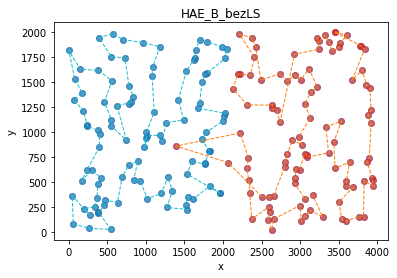

In [230]:
summarize(resultHaeB, resultValHaeB, timeHaeB, "HAE_B_bezLS", dataArrB)
#summarize(resultHae1, resultValHae1, timeHae1, "HAE_bez_LS_B", dataArrB)

In [392]:
def hae_a(experimentId, time_avg=100):
    
    population_size = 4
    population = []
    population_val = []
    while len(population) < population_size:
        p1, p2 = selectStartingPoints(experimentId)
        start, startVal = greedy_start(experimentId, p1, p2)
        bestR, bestV = steepestE(experimentId, start, startVal)
        if (bestV[0]+bestV[1]) not in population_val:
            best0 = np.insert(bestR[0], 0, bestR[0][-1])
            best1 = np.insert(bestR[1], 0, bestR[1][-1])
            population.append([best0, best1])
            population_val.append(bestV[0]+bestV[1])
    pop = np.array(population)
    pop_val = np.array(population_val)
    start_time = datetime.datetime.now()
    
    execution_time = 0
    while execution_time < time_avg:
        max_id = len(pop) - 1 
        parents = [0,0]
        parents[0] = random.randint(0, max_id)
        parents[1] = random.randint(0, max_id)
        while parents[1] == parents[0]:
            parents[1] = random.randint(0, max_id)
        newChild = [[],[]]
        for parentId in range(0, 2):
            nextParent = 0 if parentId == 1 else 1
            for x in range(1, len(pop[parents[parentId]][parentId])-1):
                value = pop[parents[parentId]][parentId][x] #obecnie sprawdzany nr wierzchołka
                p_id = list(zip(*np.where(pop[parents[nextParent]] == value)))
                if len(p_id) == 1:
                    if (pop[parents[parentId]][parentId][x-1] == pop[parents[nextParent]][p_id[0][0]][p_id[0][1]-1] and pop[parents[parentId]][parentId][x+1] == pop[parents[nextParent]][p_id[0][0]][p_id[0][1]+1]):
                        newChild[parentId].append(value)
        newChildA = np.array(newChild)
        if len(newChildA[0])>0 and len(newChildA[1])>0:
            newR, newV = repair(experimentId, newChildA)
            if newV[0]+newV[1] < np.max(pop_val) and newV[0]+newV[1] not in pop_val :
                max_item_d = np.argmax(pop_val)
                pop[max_item_d] = newR
                pop_val[max_item_d] = newV[0]+newV[1]

        end_time = datetime.datetime.now()    
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000   
    min_index = np.argmin(pop_val)
    result = pop[min_index]
    result_val = pop_val[min_index]
    return result, result_val, execution_time  
